In [60]:
# Import the packages we will need.
import os.path
import numpy as np
from sunraster.instr.spice import read_spice_l2_fits
import matplotlib.pyplot as plt

from astropy.modeling import models, fitting
from specutils.fitting import estimate_line_parameters
from astropy import units as u
from astropy.nddata import StdDevUncertainty
from scipy.ndimage import median_filter
from mpl_toolkits.axes_grid1 import AxesGrid

from tqdm.notebook import tqdm_notebook
import pickle

import warnings 
warnings.filterwarnings("ignore")

from specutils.fitting import fit_lines
from specutils.spectra import Spectrum1D
import EMToolKit.instruments.spice_functions_abundance as sfab
from EMToolKit.instruments.spice import contribution_func_spice
plt.rcParams['image.origin'] = 'lower'

dict_keys(['O III 703 / Mg IX 706 - SH', 'O III 703 / Mg IX 706 - LH', 'S IV 750/ Mg IX (spectral bin 2)', 'N IV 765 - Peak', 'Ne VIII 770 / Mg VIII 772 - SH', 'Ne VIII 770 / Mg VIII 772 - LH', 'S V 786 / O IV 787 - Extend', 'S IV 748 - Extended', 'S V 786 / O IV 787 - LW', 'N III 991 - SH', 'N III 991 - LH', 'O VI 1032 - Peak'])


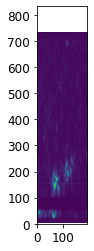

WCS Keywords

Number of WCS axes: 4
CTYPE : 'HPLN-TAN'  'HPLT-TAN'  'WAVE'  'TIME'  
CRVAL : -0.12550159332055555  -0.022513304639388887  1.03183572e-07  11543.875  
CRPIX : 96.5  417.5  9.0  1.0  
PC1_1 PC1_2 PC1_3 PC1_4  : 0.999699342516  0.00673070738133  0.0  0.0  
PC2_1 PC2_2 PC2_3 PC2_4  : -0.0893256144649  0.999699342516  0.0  0.0  
PC3_1 PC3_2 PC3_3 PC3_4  : 0.0  0.0  1.0  0.0  
PC4_1 PC4_2 PC4_3 PC4_4  : -120.25  0.0  0.0  1.0  
CDELT : 0.0011111111111111111  0.00030500000000000004  1.9246e-11  1.0  
NAXIS : 192  834  17  1


In [61]:
data_path = "mosaic"
filename = "solo_L2_spice-n-ras_20220302T091034_V02_100663686-000.fits"
file = os.path.join(data_path, filename)
exposure = read_spice_l2_fits(file,memmap=False)
print(exposure.keys())
plt.imshow(exposure['O VI 1032 - Peak'].data[0,6,:,:])
plt.show()
exposure['O VI 1032 - Peak'].data.shape
raster = exposure['O VI 1032 - Peak']
print(raster.wcs)

In [62]:
print(raster)

SpectrogramCube
---------------
Time Period: ['2022-03-02 09:11:34.648' '2022-03-02 15:34:22.398']
Instrument axes: ['raster scan' 'spectral' 'slit' 'slit step']
Pixel dimensions: [  1  17 834 192] pix
Longitude range: [-844.90413306  -58.70800953] arcsec
Latitude range: [-547.59231569  385.49678403] arcsec
Spectral range: [1.03029604e-07 1.03337540e-07] m
Data unit: adu


In [63]:
bin_facs = np.array([1, 2, 1])

def substract_min_cube(cube):
    det_plane_min = np.nanmin(cube,axis=0)
    for i in range(0,cube.shape[0]): 
        cube[i,:,:] -= det_plane_min
    return cube

def bindown(d,n):
    inds = np.ravel_multi_index(np.floor((np.indices(d.shape).T*n/np.array(d.shape))).T.astype(np.uint32),n)
    return np.bincount(inds.flatten(),weights=d.flatten(),minlength=np.prod(n)).reshape(n)

In [66]:
shotnoise_fac = 0.025*np.sqrt(10)
noisefloor = 0.07
tot_sum_amps = []
tot_sum_err = []
keys = ['O III 703 / Mg IX 706 - SH', 'Ne VIII 770 / Mg VIII 772 - SH', 'O VI 1032 - Peak']
for key in keys :
    raster = exposure[key]
    raster_yl = 750
    raster_yh = 50
    cube = raster[0].data.transpose([2,1,0])[:,raster_yh:raster_yl,:]
    cube = substract_min_cube(cube)
    cube = bindown(cube,np.round(np.array(cube.shape)/bin_facs).astype(np.int32))
    #mask and filter
    dat_arr = cube
    dat_filt = median_filter(dat_arr,size=3)
    filt_thold = 1.0
    dat_median = np.nanmedian(np.abs(dat_filt))
    dat_mask = (np.isnan(dat_arr) + np.isinf(dat_arr) +
                (np.abs(dat_arr-dat_filt) > filt_thold*(dat_median+np.abs(dat_filt)))+ (dat_arr < - 0.0)) > 0

    errors = ((noisefloor**2+np.abs(dat_filt)*shotnoise_fac**2)**0.5).astype('float32')    
    nx,ny = cube.shape[0:2]
    sum_amps = np.zeros([nx,ny])
    fit_err = np.zeros([nx,ny])
    #x = raster.spectral_axis.to(u.nm)

    for i in tqdm_notebook(range(0,nx)):
        for j in range(0,ny):
            data = cube[i,j,:]*u.adu
            errs = errors[i,j,:]
            mask = dat_mask[i,j,:]
            data[mask] = 0.0*u.adu
            if(np.sum(np.logical_not(mask)) > 5):
                dat = data[np.logical_not(mask)].value
                #wvl = x[np.logical_not(mask)]
                #cont = np.min(dat)
                sum_amps[i][j] = np.nanmean(cube[i,j,:])
                fit_err[i][j] = np.abs((sum_amps[i][j]/np.nansum(data[mask==0].value))*np.sqrt(np.nansum((errs[mask==0])**2)))  
    tot_sum_amps.append(sum_amps)
    tot_sum_err.append(fit_err)

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

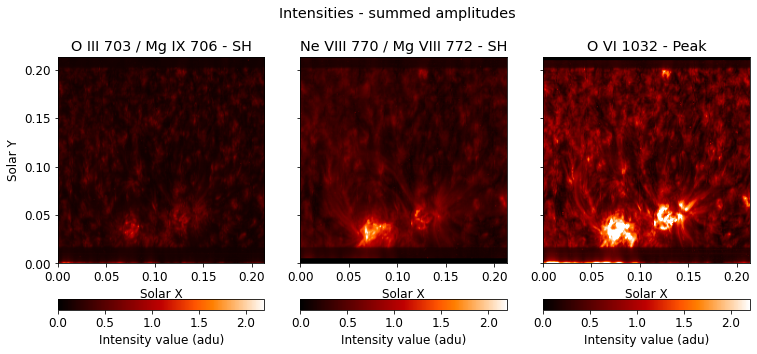

In [96]:
fig = plt.figure(figsize=(15, 5), tight_layout=True)
grid = AxesGrid(fig, 111,
                nrows_ncols=(1, 3),
                axes_pad=0.5,
                cbar_mode='each',
                cbar_location='bottom',
                cbar_pad=0.5)

for i in range(len(keys)):
    im = grid[i].imshow((tot_sum_amps[i]**gfac).T,cmap='gist_heat',vmin=0, vmax=2.2,
                        extent = [0, cube.shape[0]*raster.wcs.wcs.cdelt[0], 0, raster.wcs.wcs.cdelt[1]*2*cube.shape[1]])
    grid[i].set(title = str(keys[i]))
    grid[i].set(ylabel = 'Solar Y')
    grid[i].set(xlabel = 'Solar X')
    cbar = grid[i].cax.colorbar(im)
    cbar.ax.set_xlabel('Intensity value (adu)')
plt.suptitle('Intensities - summed amplitudes')
plt.show()
gfac = 1.0/2.2

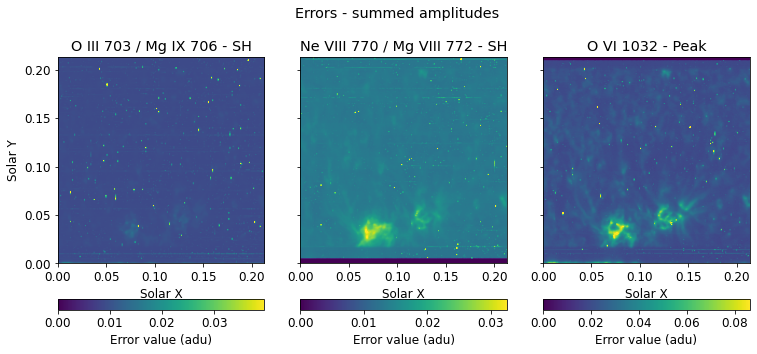

In [90]:
fig = plt.figure(figsize=(15, 5), tight_layout=True)
grid = AxesGrid(fig, 111,
                nrows_ncols=(1, 3),
                axes_pad=0.5,
                cbar_mode='each',
                cbar_location='bottom',
                cbar_pad=0.5)

for i in range(len(keys)):
    im = grid[i].imshow(tot_sum_err[i].T,cmap='viridis',vmin=0, vmax=np.quantile(tot_sum_err[i],0.999),
                        extent = [0, cube.shape[0]*raster.wcs.wcs.cdelt[0], 0, raster.wcs.wcs.cdelt[1]*2*cube.shape[1]])
    grid[i].set(title = str(keys[i]))
    grid[i].set(ylabel = 'Solar Y')
    grid[i].set(xlabel = 'Solar X')
    cbar = grid[i].cax.colorbar(im)
    cbar.ax.set_xlabel('Error value (adu)')
plt.suptitle('Errors - summed amplitudes')
plt.show()

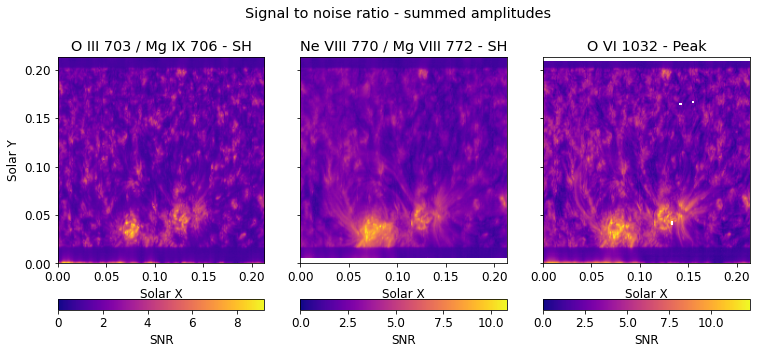

In [92]:
fig = plt.figure(figsize=(15, 5), tight_layout=True)
grid = AxesGrid(fig, 111,
                nrows_ncols=(1, 3),
                axes_pad=0.5,
                cbar_mode='each',
                cbar_location='bottom',
                cbar_pad=0.5)

for i in range(len(keys)):
    im = grid[i].imshow(((tot_sum_amps[i]/tot_sum_err[i])**gfac).T,cmap='plasma',vmin=0,
                        extent = [0, cube.shape[0]*raster.wcs.wcs.cdelt[0], 0, raster.wcs.wcs.cdelt[1]*2*cube.shape[1]])
    grid[i].set(title = str(keys[i]))
    grid[i].set(ylabel = 'Solar Y')
    grid[i].set(xlabel = 'Solar X')
    cbar = grid[i].cax.colorbar(im)
    cbar.ax.set_xlabel('SNR')
plt.suptitle('Signal to noise ratio - summed amplitudes')
plt.show()

In [76]:
## Plot
import EMToolKit.EMToolKit_SPICE as emtk
from EMToolKit.algorithms.simple_reg_dem_wrapper import simple_reg_dem_wrapper
from ndcube import NDCube, NDCubeSequence, NDCollection
import astropy.wcs
[ions, wvl] = sfab.extract_ions_wvl(keys)
file = os.path.join(data_path, filename)
##Contribution Functions 
[trespsCorona, logtsCorona, exptimes] = contribution_func_spice('sun_coronal_2012_schmelz', ions, wvl)

defaultValue = 1
tot_err_nonan = []
tot_amp_nonan = []
for k in range(len(tot_sum_err)):
    B = np.array(tot_sum_err[k])
    B[np.isnan(B)] = defaultValue
    B[ B == np.inf] = defaultValue
    B[ B == 0] = defaultValue
    tot_err_nonan.append(B)
    A = np.array(tot_sum_amps[k])
    A = np.nan_to_num(A)
    A[ A == np.inf] = defaultValue
    tot_amp_nonan.append(A)

for i in range((len(tot_amp_nonan))):
    raster = exposure[list(exposure.keys())[i]]
    tot_amp_nonan[i] = NDCube(tot_amp_nonan[i], wcs = raster[0,0].wcs, meta = {"detector": "SPICE",
                                                                               "wave_str" :list(exposure.keys())[i],
                                                                               "exptime": 20})
  

logt_arr = np.arange(4.5,6.55,0.05)
logts = []
for i in range(trespsCorona.shape[0]):
    logts.append(logt_arr)

#Time exposure for each spectral line
exptimes = np.array([20,20,20,20,20])

#Turning list of fitted amplitude into usable object (datasequence)
datasequence = emtk.em_data(tot_amp_nonan, tot_err_nonan, logts, trespsCorona)
em_collection = emtk.em_collection(datasequence)

coeffs,logts,bases,wcs,algorithm, chi2 = simple_reg_dem_wrapper(em_collection.data())
demsequence = emtk.dem_model(coeffs,logts,bases,wcs,algorithm,simple_reg_dem_wrapper)
em_collection.add_model(demsequence)

demmax = 5.0e28
gfac = 1.0/2.2

Shape tresps :  (3, 41)
Length logts :  3
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
41


  0%|          | 0/192 [00:00<?, ?it/s]

<Figure size 1080x1080 with 0 Axes>

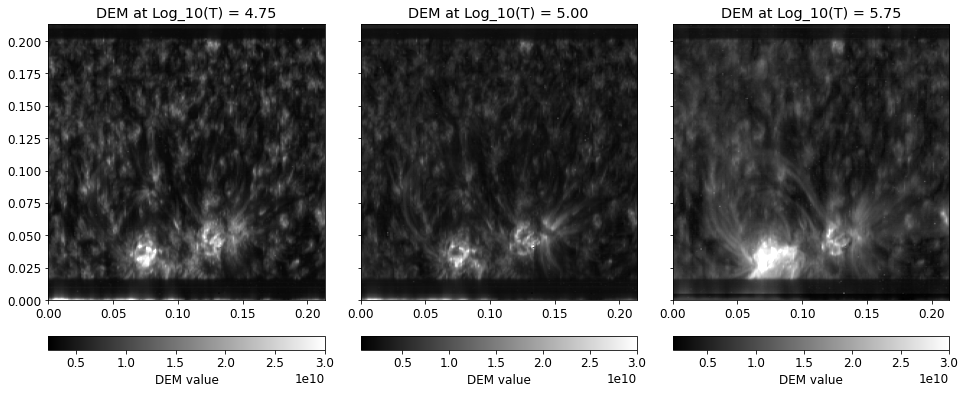

In [77]:
plt.figure(figsize=(15,15))
tempindx = [5,10,25]

from mpl_toolkits.axes_grid1 import AxesGrid
fig = plt.figure(figsize=(20, 6), constrained_layout=True)
grid = AxesGrid(fig, 111,
                nrows_ncols=(1, 3),
                axes_pad=0.5,
                cbar_mode='each',
                cbar_location='bottom',
                cbar_pad=0.5)

for i in range(len(keys)):
    #grid[i].set_axis_off()
    im = grid[i].imshow((demsequence[tempindx[i],:,:].data**gfac).T, 
                        extent = extent,
                        vmax=3e10,cmap=plt.get_cmap('gray'))
    grid[i].set(title = 'DEM at Log_10(T) = '+ "%.2f" % demsequence[tempindx[i]].meta['logt0'])

    cbar = grid[i].cax.colorbar(im)
    #cbar = grid.cbar_axes[0].colorbar(im)
    cbar.ax.set_xlabel('DEM value')
plt.show()

Shape tresps :  (3, 41)
Length logts :  3
Shape tresps :  (3, 41)
Length logts :  3
(41,)
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: un

  0%|          | 0/21 [00:00<?, ?it/s]

41


  0%|          | 0/192 [00:00<?, ?it/s]

41


  0%|          | 0/192 [00:00<?, ?it/s]

41


  0%|          | 0/192 [00:00<?, ?it/s]

41


  0%|          | 0/192 [00:00<?, ?it/s]

41


  0%|          | 0/192 [00:00<?, ?it/s]

41


  0%|          | 0/192 [00:00<?, ?it/s]

41


  0%|          | 0/192 [00:00<?, ?it/s]

41


  0%|          | 0/192 [00:00<?, ?it/s]

41


  0%|          | 0/192 [00:00<?, ?it/s]

41


  0%|          | 0/192 [00:00<?, ?it/s]

41


  0%|          | 0/192 [00:00<?, ?it/s]

41


  0%|          | 0/192 [00:00<?, ?it/s]

41


  0%|          | 0/192 [00:00<?, ?it/s]

41


  0%|          | 0/192 [00:00<?, ?it/s]

41


  0%|          | 0/192 [00:00<?, ?it/s]

41


  0%|          | 0/192 [00:00<?, ?it/s]

41


  0%|          | 0/192 [00:00<?, ?it/s]

41


  0%|          | 0/192 [00:00<?, ?it/s]

41


  0%|          | 0/192 [00:00<?, ?it/s]

41


  0%|          | 0/192 [00:00<?, ?it/s]

41


  0%|          | 0/192 [00:00<?, ?it/s]

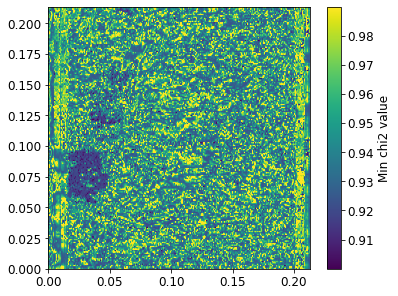

In [70]:
import EMToolKit.EMToolKit_SPICE as emtk
from EMToolKit.algorithms.simple_reg_dem_wrapper import simple_reg_dem_wrapper
from ndcube import NDCube, NDCubeSequence, NDCollection
import astropy.wcs
extent = [0, cube.shape[0]*raster.wcs.wcs.cdelt[0], 0, raster.wcs.wcs.cdelt[1]*2*cube.shape[1]]
[tot_fit_amps, tot_errors] = [tot_sum_amps, tot_sum_err]
[ions, wvl] = sfab.extract_ions_wvl(keys)
file = os.path.join(data_path, filename)
##Contribution Functions 
[trespsCorona, logtsCorona, exptimes] = contribution_func_spice('sun_coronal_2012_schmelz', ions, wvl)
[trespsPhoto, logtsPhoto, exptimes] = contribution_func_spice('sun_photospheric_2015_scott', ions, wvl)
#mix the coronal and photosphere abundances from 0% to 100%
mixed_tresps = []
for i in range (0,101,5):
    mix = trespsCorona*(i/100)+trespsPhoto*(1-i/100)
    mixed_tresps.append(mix)

##DEMs
list_chi2 =[]
datasequences = []
em_collections =[]
print(logtsCorona[0].shape)
for i in mixed_tresps :
    datasequences.append(emtk.em_data_spice(file, keys, tot_fit_amps, tot_errors, logtsCorona, i))
for k in datasequences :    
    em_collections.append(emtk.em_collection(k))

for j in tqdm_notebook(em_collections) :
    coeffs,logts,bases,wcs,algorithm, chi2 = simple_reg_dem_wrapper(j.data())
    list_chi2.append(chi2)
    demsequence = emtk.dem_model(coeffs,logts,bases,wcs,algorithm,simple_reg_dem_wrapper)
    j.add_model(demsequence)

[chi_mins, chi_mins_idx] = sfab.chi2_mins(list_chi2, extent)


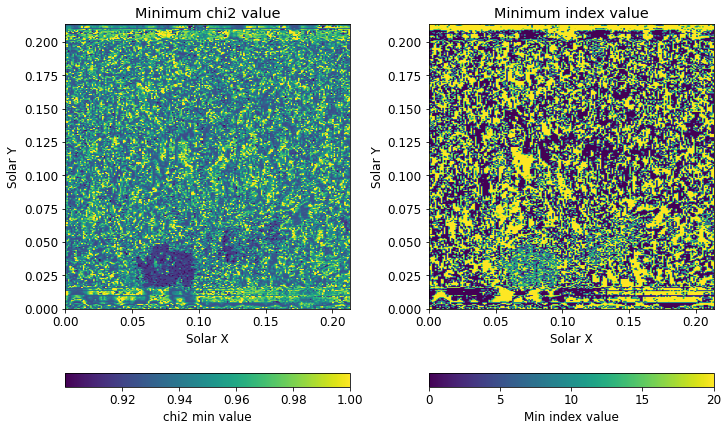

In [71]:
plt.figure(figsize=[10,8], constrained_layout=True)
plt.subplot(1,2,1)
plt.imshow(chi_mins.T, extent=extent, vmax=1)
c = plt.colorbar(location = 'bottom')
c.ax.set_xlabel('chi2 min value')
plt.ylabel('Solar Y')
plt.xlabel('Solar X')
plt.title('Minimum chi2 value');
plt.subplot(1,2,2)
plt.imshow(chi_mins_idx.T, extent=extent)
c = plt.colorbar(location = 'bottom')
c.ax.set_xlabel('Min index value')
plt.ylabel('Solar Y')
plt.xlabel('Solar X')
plt.title('Minimum index value');

val quantile 0.95 :  1.0586644024437002
val quantile 0.95 :  3.7307415761939153
val quantile 0.95 :  14.011568036093296


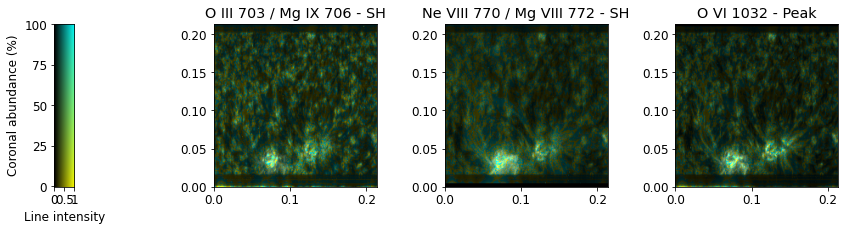

In [72]:
##Plot the coronal abundances / line intensity
cb_img = sfab.clrbar_ab_int()
plt.figure(figsize=[20,3])
gfac=1/2.2
clrimg = np.zeros([chi_mins.shape[0], chi_mins.shape[1], 3])
gimg = np.ones(chi_mins_idx.shape)
bimg = chi_mins_idx/20
rimg = np.ones(chi_mins_idx.shape) - bimg
plt.rcParams.update({'font.size':12})
for i in range(len(keys)):
    lines = i
    val = np.nanquantile(tot_fit_amps[lines], 0.999) 
    print('val quantile 0.95 : ', val)
    clrimg[:,:,0] = rimg*np.clip(tot_fit_amps[lines], 0, val)/val
    clrimg[:,:,1] = gimg*np.clip(tot_fit_amps[lines], 0, val)/val
    clrimg[:,:,2] = bimg*np.clip(tot_fit_amps[lines], 0, val)/val
    plt.subplot(1,5,i+2)
    plt.imshow((clrimg**gfac).transpose([1,0,2]),
               extent = [0, cube.shape[0]*exposure[keys[i]].wcs.wcs.cdelt[0],
                         0, exposure[keys[i]].wcs.wcs.cdelt[1]*2*cube.shape[1]])   
    plt.title(str(keys[lines]))
plt.subplot(1,5,1)
locsx, labelsx = plt.xticks()
locsy, labelsy = plt.yticks()
labelsx, locsx = [0, 0.5, 1], np.linspace(0,31,3)
labelsy, locsy = [0, 25, 50, 75, 100], np.linspace(0,255,5)
plt.xticks(locsx, labelsx), plt.xlabel('Line intensity')
plt.yticks(locsy, labelsy), plt.ylabel('Coronal abundance (%)')
plt.imshow(cb_img)
plt.show()

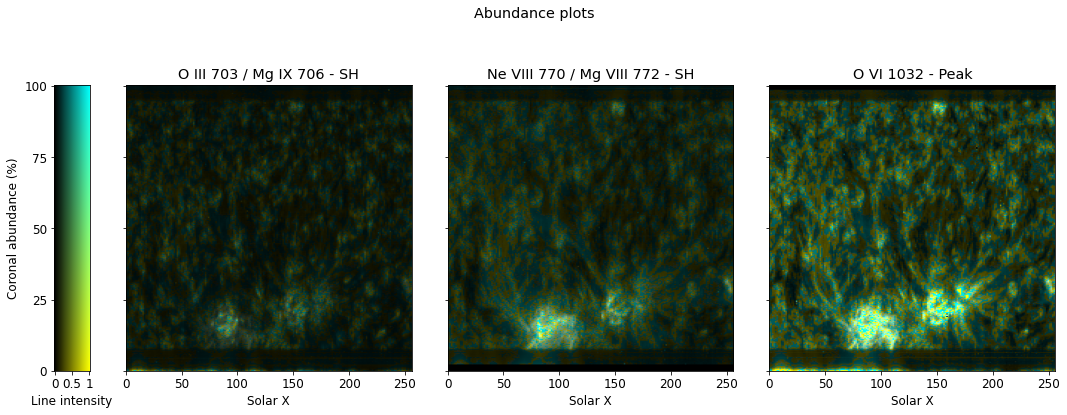

In [75]:
fig = plt.figure(figsize=(15, 6),tight_layout=True)  #figsize=(15, 6)
grid = AxesGrid(fig, 111,
                nrows_ncols=(1, 4),
                axes_pad=0.5)

grid[0].imshow(cb_img)
locsx, labelsx = plt.xticks()
locsy, labelsy = plt.yticks()
labelsx, locsx = [0, 0.5, 1], np.linspace(0,31,3)
labelsy, locsy = [0, 25, 50, 75, 100], np.linspace(0,255,5)
grid[0].set_xticks(locsx, labelsx); grid[0].set_xlabel('Line intensity')
grid[0].set_yticks(locsy, labelsy); grid[0].set_ylabel('Coronal abundance (%)')

for i in range(len(keys)):
    val = np.nanquantile(tot_fit_amps[lines], 0.99) 
    clrimg[:,:,0] = rimg*np.clip(tot_fit_amps[i], 0, val)/val
    clrimg[:,:,1] = gimg*np.clip(tot_fit_amps[i], 0, val)/val
    clrimg[:,:,2] = bimg*np.clip(tot_fit_amps[i], 0, val)/val
    im = grid[i+1].imshow((clrimg**gfac).transpose([1,0,2]),
               extent = [0, cube.shape[0]*exposure[keys[i]].wcs.wcs.cdelt[0]*1200,
                         0, exposure[keys[i]].wcs.wcs.cdelt[1]*2*cube.shape[1]*1200])
    grid[i+1].set(title = str(keys[i]))
    grid[i+1].set(xlabel = 'Solar X')
    grid[i+1].set(ylabel = 'Solar Y')

plt.suptitle('Abundance plots')
plt.show()